## Multinomial with Dirichlet prior on the probabilities

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import edward as ed
import tensorflow as tf
from edward.models import Multinomial, Dirichlet
import seaborn as sns

*Set up the model.* Consider a trinomial random variable with a Dirichlet prior on its probability vector. The hyperparameter $\alpha$ of the prior is set to a fixed number. The higher the number the less effect subsequent observations of $y$ have on the probability vector. We observe $6 * N$ samples of $y$. 

In [48]:
N = 10
alpha = 10.
p = Dirichlet(tf.constant(alpha, shape=(3,)))
y = Multinomial(total_count=N * 6., probs=p)

*Approximate the posterior.* This is possible since we are dealing with a conjugate prior, and hence we do not have to deal with the difficulty of approximating the posterior. Although computing the posterior is tractable, we choose to approximate it with an empirical distribution from a sampled data set. The sampling method is called Gibbs sampling and is for example explained in [Bishop]. 

In [49]:
T = 500
with tf.variable_scope("q", reuse=tf.AUTO_REUSE):
    qp = ed.models.Empirical(tf.Variable(tf.zeros(shape=(T, 3))))
inference = ed.Gibbs({p: qp}, data={y: [N * i for i in [4., 1., 1.]]})
inference.run()

500/500 [100%] ██████████████████████████████ Elapsed: 1s | Acceptance Rate: 1.000


*Plot the results.* A number of parameters effect the shape of the density plots:
1. $\alpha$ - Depends. An intuitive explanation is to see the $(\alpha, \alpha, \alpha)$ as a vector of pseudo-counts that is not aligned with the observations. My guess is that the estimated width of the distributions is a convex function of $\alpha$. For lower values the width is increasing, for higher values it is decreasing in $\alpha$. 
2. $N$ - Depends. The higher the narrower the density plots (for fixed $\alpha$). More observations means less uncertainty.

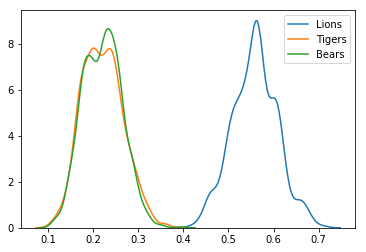

In [50]:
samples = qp.sample(1000).eval()
sns.kdeplot(data=samples[:,0], label="Lions")
sns.kdeplot(samples[:,1], label="Tigers")
sns.kdeplot(samples[:,2], label="Bears");

## Unsupervised learning (Edward tutorial)

In [65]:
import numpy as np

def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    return x

N = 500
D = 2
x_train = build_toy_dataset(N)

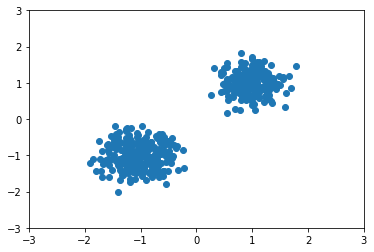

In [83]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

In [ ]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture

K = 2 # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)